**The prediction of significant wave height (Hs) using ARIMA**

In physical oceanography, the significant wave height (SWH or Hs) is defined traditionally as the mean wave height (trough to crest) of the highest third of the waves (H1/3). It is scientifically represented as Hs or Hsig, is an important parameter for the statistical distribution of ocean waves. The most common waves are lower in height than Hs. This implies that encountering the significant wave is not too frequent. However, statistically, it is possible to encounter a wave that is much higher than the significant wave. 


To predict the significant wave height, I  will analyze measured data collected by oceanographic wave measuring buoys anchored at Mooloolaba. Coverage period: 30 months collected at periods of 30 min intervals.
The data comes from Queensland Government Data - https://data.qld.gov.au/dataset. I will use ARIMA method to predict the Hs values useing walk forward validation with a sliding window of 3000 time steps.

We begin the analysis by importing the needed libraries and the data set.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
print(os.listdir('../input'))

['Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv']


Now you're ready to read in the data and use the plotting functions to visualize the data.

In [3]:
# Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv has 43728 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('../input/Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv',index_col=0, parse_dates=True,nrows=24000)
df1.dataframeName = 'Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1.head()

There are 24000 rows and 6 columns


,Hs,Hmax,Tz,Tp,Peak Direction,SST
Date/Time,,,,,,
2017-01-01 00:00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
2017-01-01 00:30:00,0.875,1.39,4.421,4.506,-99.9,-99.90
2017-01-01 01:00:00,0.763,1.15,4.520,5.513,49.0,25.65
2017-01-01 01:30:00,0.770,1.41,4.582,5.647,75.0,25.50
2017-01-01 02:00:00,0.747,1.16,4.515,5.083,91.0,25.45


Lets prepare the data by replacing the mising values by interpolated data.

In [4]:
df1=df1.replace(-99.9,np.nan)
df1=df1.interpolate(limit_direction='both')

In [5]:
def plot_df(x, y, title, xlabel, ylabel, dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()



In [6]:
# Create Training and Test
train = df1.iloc[:3000,1]
test = df1.iloc[3000:3200,1]

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


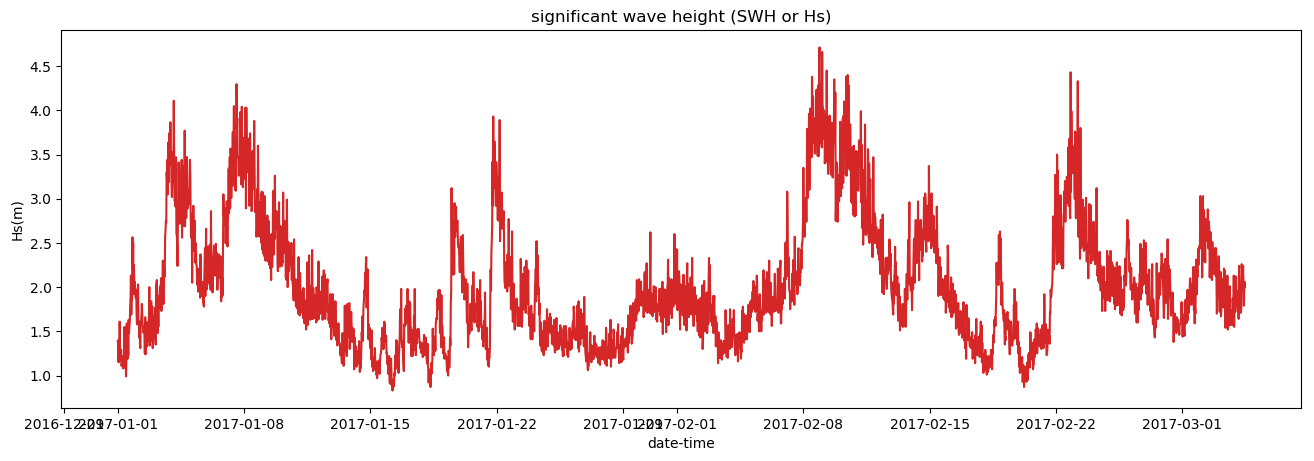

In [7]:
plot_df( train.index, train.values, "significant wave height (SWH or Hs)", "date-time", "Hs(m)")

ARIMA MODEL

finding d

In [8]:
result=adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result_diff = adfuller(train.diff().dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

ADF Statistic: -4.097633
p-value: 0.000977
ADF Statistic: -40.896897
p-value: 0.000000


The series is stationary after one differencing, thus d=1

Finding P

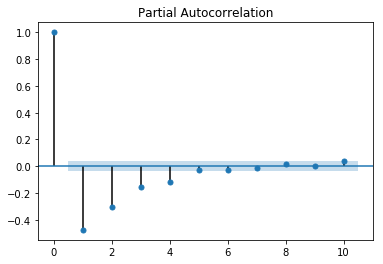

In [9]:
x=plot_pacf((train.diff()).dropna(),lags=10)

A value of p=5 should be fine.

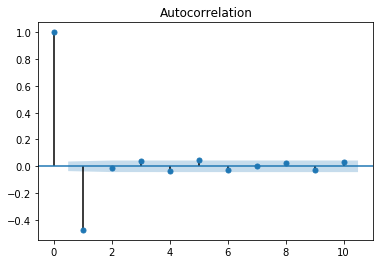

In [10]:
x=plot_acf((train.diff()).dropna(),lags=10)

We found a value of q=2.

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


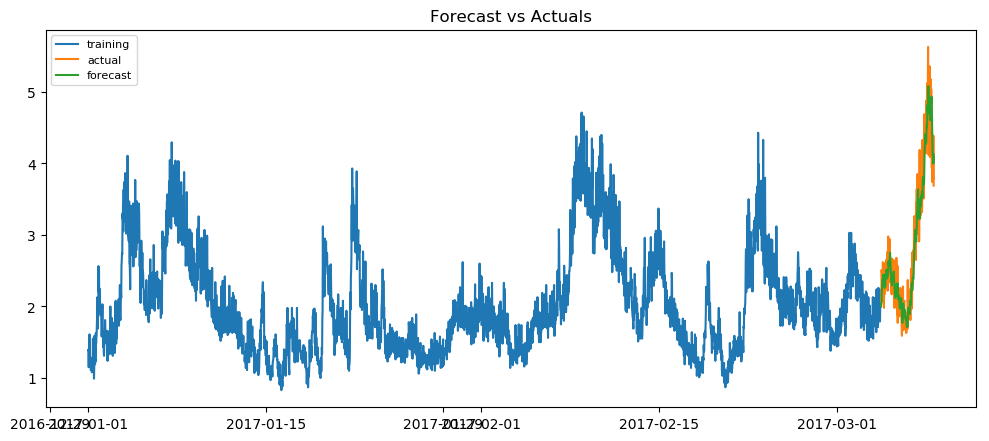

In [11]:
# Build Model
predictions=[]
history=[x for x in train]
for t in range(len(test)):
    model = ARIMA(history[t:], order=(5, 1, 2))
    model_fit = model.fit()
    predictions.append(model_fit.forecast(alpha=0.05)[0][0])
    history.append(test[t])
# Forecast
# Make as pandas series
predictions = pd.Series(predictions, index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(predictions, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


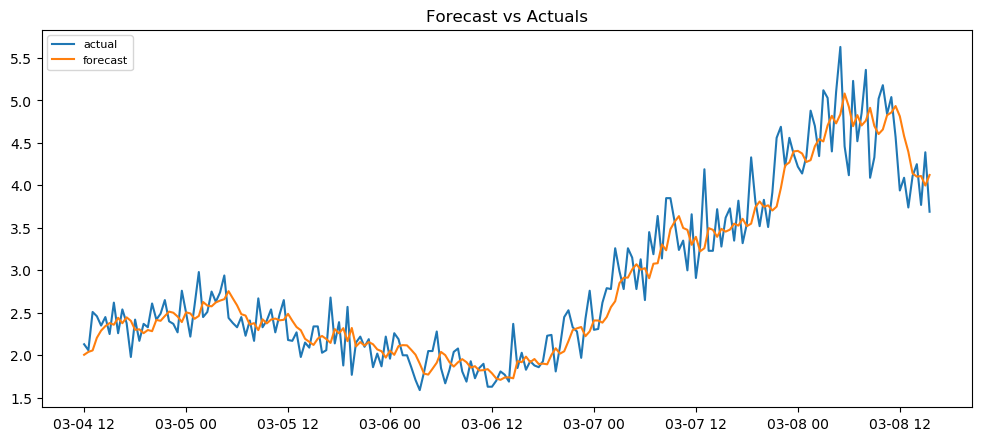

In [12]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(predictions, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

RMSE: 0.314


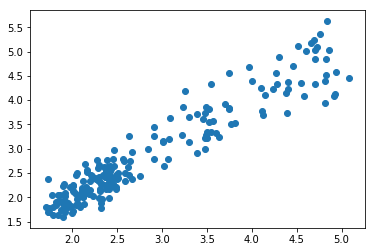

In [13]:
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.scatter(predictions,test)

In [14]:
x=np.array(test)
y=np.array(predictions)
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions,test.iloc[:])
print(r_value)

0.9484749935594794


## Conclusion
My model is simple. I use data from last two months to predict (Hs) for the next step. I use walk forward
validation with a sliding window of 3000 time steps (62.5 days). The model is tested for successive 200 time steps (10 hours). On average the difference between the predicted and actual data is about 31cm. The predictions and the actual data are also tested with a linear regression and found R value of 0.94. The results are very promising and could be enhanced further by optimizing the training window size.
